# Simulate using scATAC-Seq

## Import your packages

In [1]:
import numpy as np
import pandas as pd

import scanpy as sc
import episcanpy as epi
import anndata as ad
import seaborn as sns

import matplotlib.pyplot as plt

import time
import pickle
import os
from scipy import sparse

### Import R related packages

In [2]:
import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
import logging

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

### Data

In [3]:
file_path = 'data/'
os.listdir(file_path) # shows all files in file_path

['.ipynb_checkpoints',
 'atac_v1_adult_brain_fresh_5k_fragments.tsv.gz',
 '5k_brain_peaks.narrowPeak',
 'atac_v1_adult_brain_fresh_5k_singlecell.csv',
 '10x-ATAC-Brain5k.h5ad',
 'gencode.vM25.basic.annotation.gtf.gz',
 'description.md']

In [4]:
name = "5k_brain"

base_dir = "{}".format(file_path)

peak_file = base_dir + "{}_peaks.narrowPeak".format(name)
fragments_file = base_dir + "atac_v1_adult_brain_fresh_5k_fragments.tsv.gz"

gtf_file = base_dir + "gencode.vM25.basic.annotation.gtf.gz"

<br><h3>Load and filter barcode information</h3>

In [5]:
barcode_info = pd.read_csv(base_dir + "atac_v1_adult_brain_fresh_5k_singlecell.csv")
print(barcode_info.is__cell_barcode.value_counts())

0    495824
1      3880
Name: is__cell_barcode, dtype: int64


In [6]:
valid_barcodes = barcode_info[barcode_info.is__cell_barcode == 1].barcode.tolist()

<br><h3>Load and add annotation</h3>

In [7]:
anno = ad.read(base_dir + "10x-ATAC-Brain5k.h5ad")

In [8]:
anno_per_bc = {bc: anno for bc, anno in zip(anno.obs.index, anno.obs.cell_type)}

In [9]:
adata = epi.ct.window_mtx(
    fragments_file,
    valid_barcodes,
    window_size=100000,
    species="human",
    fast=True
)

In [10]:
adata.obs["cell_type"] = [anno_per_bc[bc] if bc in anno_per_bc else "No Annotation" for bc in adata.obs.index.tolist()]
cell_types = set(adata.obs['cell_type']) - {'No Annotation'}

In [11]:
adata

AnnData object with n_obs × n_vars = 3880 × 30877
    obs: 'cell_type'
    var: 'chr', 'start', 'stop'

### Simulate data

In [12]:
%%R
library(simATAC)

simulate <- function(data, nCells) {
    print("Simulating data...")
    print("Data shape:")
    print(dim(data))
    obj <- simATACEstimate(data)
    simATACSimulate(obj, nCells=nCells)
}

In [23]:
adata_by_cell_type = {}
for cell_type in cell_types:
    print(f'Simulating data for cell type {cell_type}')
    tmp = adata[adata.obs['cell_type'] == cell_type]
    rdata = anndata2ri.py2rpy(tmp)
    ro.globalenv['tmp'] = rdata
    adata_by_cell_type[cell_type] = ro.r(f'simulate(tmp, {tmp.shape[0]})').X


Simulating data for cell type L6 CT
[1] "Simulating data..."
[1] "Data shape:"
[1] 30877   339


Simulating data for cell type L4
[1] "Simulating data..."
[1] "Data shape:"
[1] 30877   435


Simulating data for cell type Sst
[1] "Simulating data..."
[1] "Data shape:"
[1] 30877    74


Simulating data for cell type Vip
[1] "Simulating data..."
[1] "Data shape:"
[1] 30877   106


Simulating data for cell type Pvalb
[1] "Simulating data..."
[1] "Data shape:"
[1] 30877   107


Simulating data for cell type L5 IT
[1] "Simulating data..."
[1] "Data shape:"
[1] 30877   331


Simulating data for cell type NP
[1] "Simulating data..."
[1] "Data shape:"
[1] 30877    35


Simulating data for cell type L5 PT
[1] "Simulating data..."
[1] "Data shape:"
[1] 30877    83


Simulating data for cell type L2/3 IT
[1] "Simulating data..."
[1] "Data shape:"
[1] 30877   604


Simulating data for cell type L6 IT
[1] "Simulating data..."
[1] "Data shape:"
[1] 30877   158


In [51]:
tmp = sparse.vstack(list(adata_by_cell_type.values()))
obs_df = pd.DataFrame(index=[f'Cell_{i}' for i in range(tmp.shape[0])])
adata_sim = ad.AnnData(tmp, obs=obs_df, var=adata.var.copy())
del tmp

In [52]:
sim_cell_types = []
for cell_type, mtx in adata_by_cell_type.items():
    sim_cell_types.extend([cell_type] * mtx.shape[0])
adata_sim.obs['cell_type'] = sim_cell_types
adata_sim

AnnData object with n_obs × n_vars = 2272 × 30877
    obs: 'cell_type'
    var: 'chr', 'start', 'stop'

<br><hr><br><br><h3>Binarize the matrix and compute QC metrics</h3>

### Poisson assumption

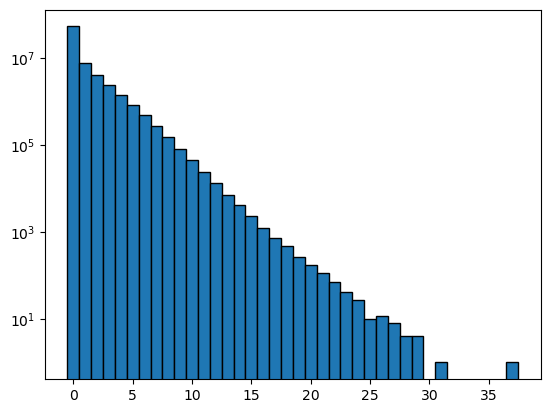

In [53]:
fig = plt.figure()
ax = fig.add_subplot()
data=adata_sim.X.toarray().flatten()
bins = np.arange(0, data.max() + 1.5) - 0.5
ax.hist(data, log=True, bins=bins, edgecolor='black')
del data

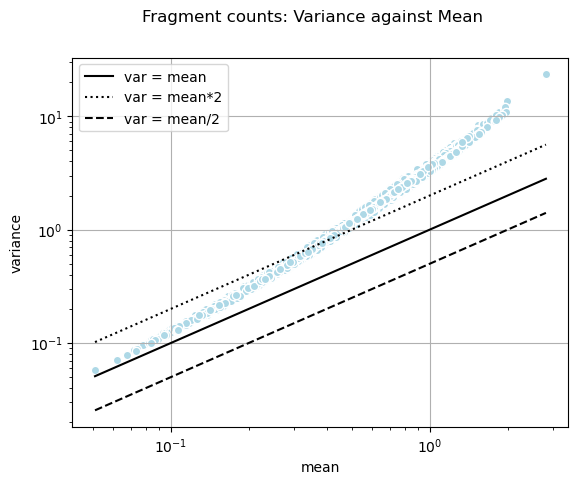

In [54]:
means = np.apply_along_axis(np.mean, 1, adata_sim.X.toarray())
variances = np.apply_along_axis(np.var, 1, adata_sim.X.toarray())
x_min = np.min(means)
x_max = np.max(means)
fig = plt.figure()
ax = fig.add_subplot()
ax.grid()
fig.suptitle('Fragment counts: Variance against Mean')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean')
ax.set_ylabel('variance')

ax.scatter(means, variances, color='lightblue', edgecolors='white')
ax.plot([x_min,x_max], [x_min,x_max], color='black', label='var = mean')
ax.plot([x_min,x_max], [2*x_min,2*x_max], color='black', linestyle='dotted', label='var = mean*2')
ax.plot([x_min,x_max], [x_min / 2,x_max / 2], color='black', linestyle='dashed', label='var = mean/2')
ax.legend()

In [55]:
print("Max before:\t{}".format(np.max(adata_sim.X)))
epi.pp.binarize(adata_sim)
print("Max after:\t{}".format(np.max(adata_sim.X)))

Max before:	37.0
Max after:	1.0


In [56]:
epi.pp.qc_stats(adata_sim, verbose=True)

added keys n_cells, log_n_cells to .var
added keys n_features, log_n_features to .obs


<br><hr><br><br><h3>Normalization and log-transformation</h3>

### log1p proportional fitting

In [57]:
# proportional fitting to mean of cell depth
proportional_fitting = epi.pp.normalize_total(adata_sim, target_sum=None, inplace=False)
# log1p transform
adata_sim.layers["log1pPF_normalization"] = epi.pp.log1p(adata_sim, copy=True).X

### scran normalization

In [58]:
%%R
library(scran)
library(BiocParallel)

In [59]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata_sim.copy()
epi.pp.normalize_total(adata_pp)
epi.pp.log1p(adata_pp)
epi.pp.pca(adata_pp, n_comps=15)
epi.pp.neighbors(adata_pp)
epi.tl.leiden(adata_pp, key_added="groups")

In [60]:
import scipy

data_mat = adata_sim.X.T
# convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70
if scipy.sparse.issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["groups"]

In [61]:
del adata_pp

In [62]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In [63]:
adata_sim.obs["size_factors"] = size_factors
scran = adata_sim.X / adata_sim.obs["size_factors"].values[:, None]
adata_sim.layers["scran_normalization"] = sparse.csr_matrix(sc.pp.log1p(scran))

In [64]:
adata_sim.layers['raw'] = adata_sim.X
adata_sim

AnnData object with n_obs × n_vars = 2272 × 30877
    obs: 'cell_type', 'n_features', 'log_n_features', 'size_factors'
    var: 'chr', 'start', 'stop', 'n_cells', 'log_n_cells'
    layers: 'log1pPF_normalization', 'scran_normalization', 'raw'

In [65]:
adata_sim.X = adata_sim.layers['scran_normalization']

<br><hr><br><br><h3>QC visualization + determine filtering thresholds</h3>

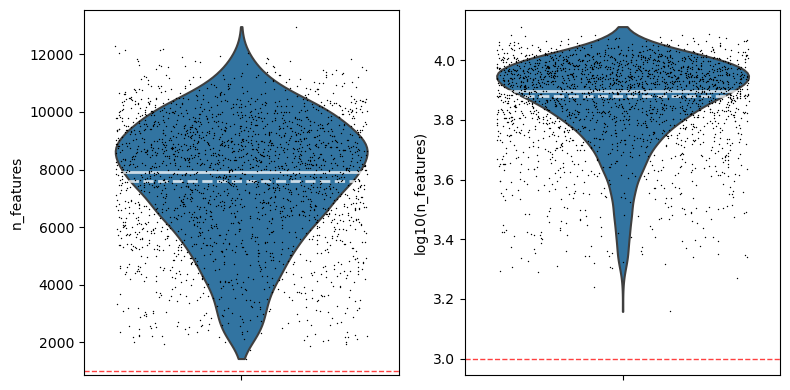

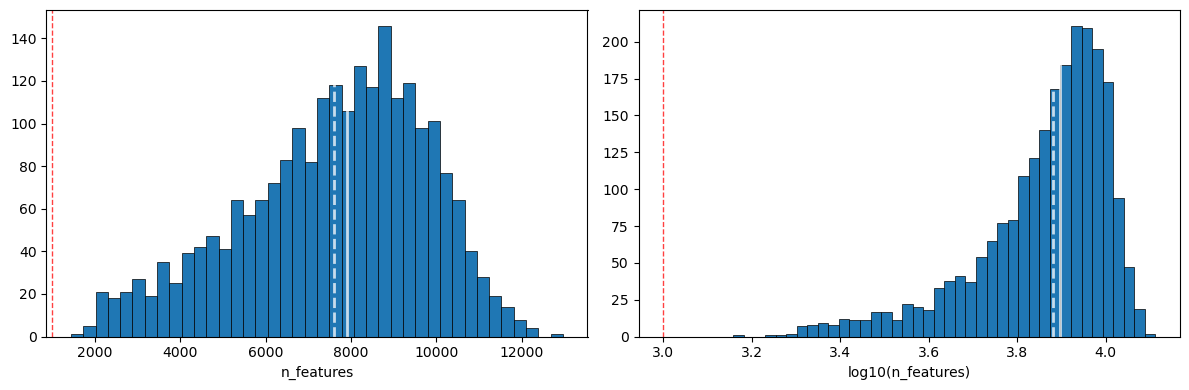

Max:	12964
Median:	7901.5
Mean:	7602.315580985915
Min:	1439


In [66]:
min_features = 1000
max_features = None

epi.pl.violin(adata_sim, "n_features", min_threshold=min_features, max_threshold=max_features, show_log=True, show_mean=True, show_median=True, print_statistics=False, save=None)
epi.pl.histogram(adata_sim, "n_features", bins=40, min_threshold=min_features, max_threshold=max_features, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

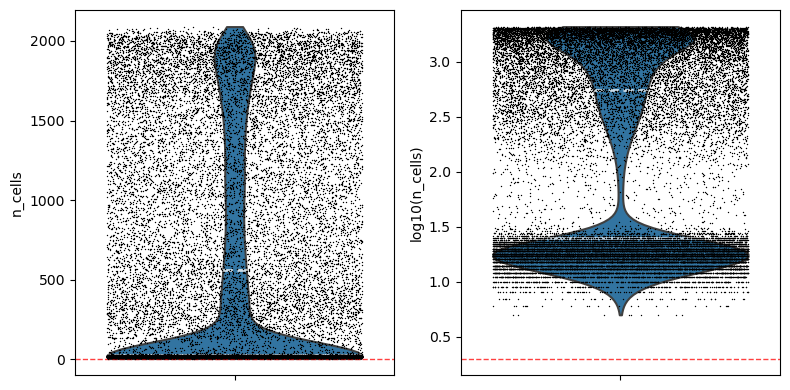

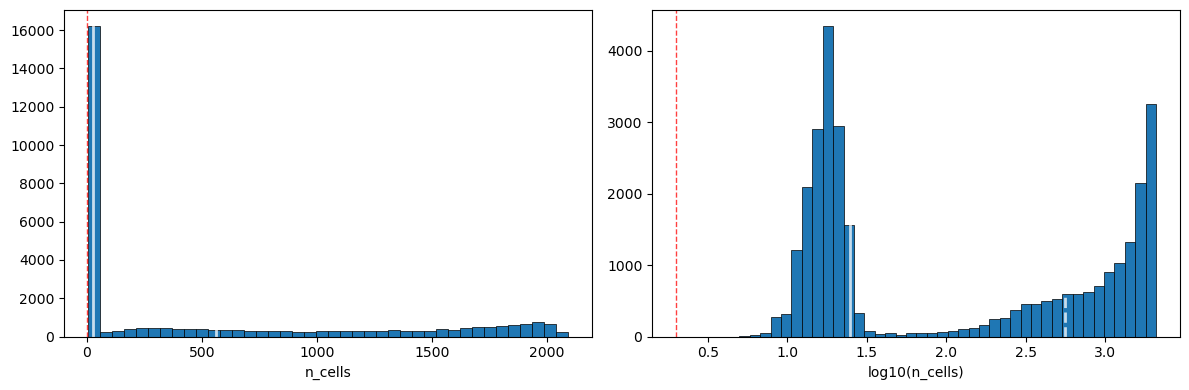

Max:	2090
Median:	25.0
Mean:	559.3956990640282
Min:	5


In [67]:
min_cells = 2
max_cells = None

epi.pl.violin(adata_sim, "n_cells", min_threshold=min_cells, max_threshold=max_cells, show_log=True, show_mean=True, show_median=True, print_statistics=False, save=None)
epi.pl.histogram(adata_sim, "n_cells", bins=40, min_threshold=min_cells, max_threshold=max_cells, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

<br><hr><br><br><h3>Set, check, and apply filters</h3>

In [68]:
epi.pp.set_filter(adata_sim, "n_features", min_threshold=min_features, max_threshold=max_features)
epi.pp.set_filter(adata_sim, "n_cells", min_threshold=min_cells)

2272 of 2272 observations remain (0)
30877 of 30877 features remain (0)


In [69]:
adata_sim = epi.pp.apply_filters(adata_sim, verbose=True)

2272 of 2272 observations remain (0)
30877 of 30877 features remain (0)


<br><hr><br><br><h3>Select highly variable features</h3>

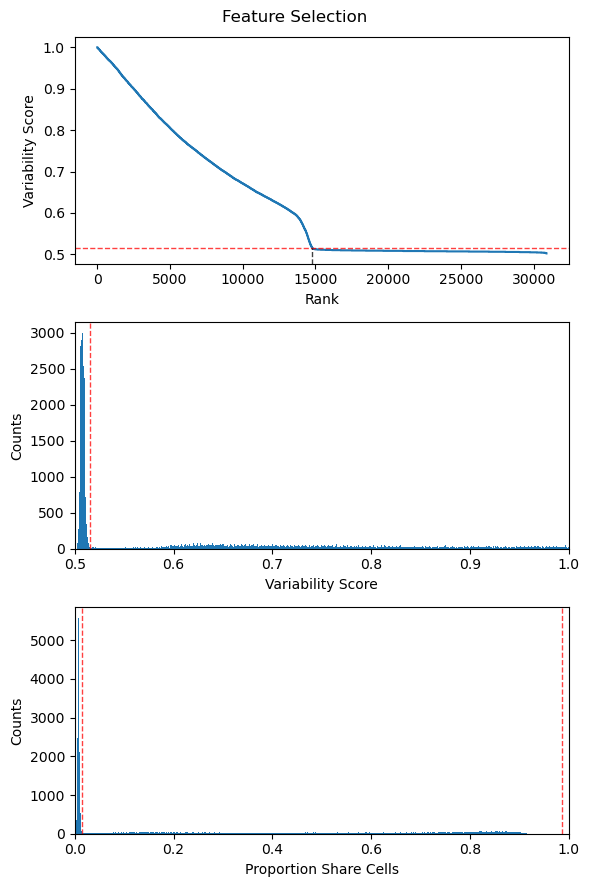

In [70]:
epi.pp.highly_variable(adata_sim, min_score=0.515, n_features=None)

In [72]:
adata_sim = epi.pp.select_highly_variable(adata_sim, verbose=True)

14779 of 30877 features remain (-16098)


<br><hr><br><br><h3>Principal component analysis, neighborhood graph, UMAP, and visualization</h3>

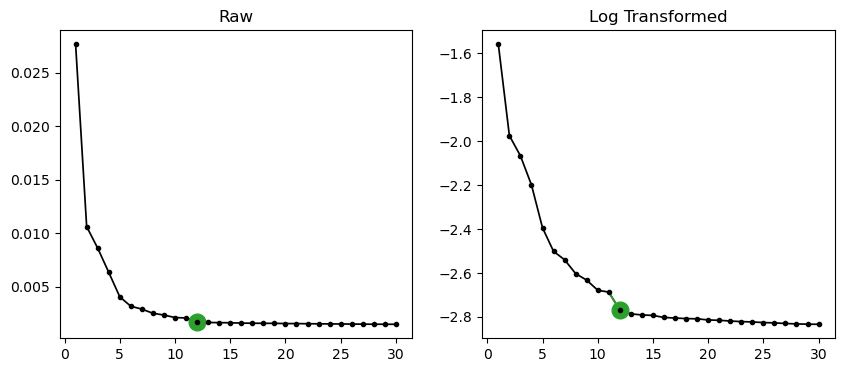

In [73]:
epi.pp.pca(adata_sim, n_comps=30)
n_comps = epi.pp.find_elbow(adata_sim, use_log=True, show_anno=False)

In [74]:
epi.pp.neighbors(adata_sim, n_pcs=n_comps, method="umap")

In [75]:
epi.tl.umap(adata_sim)

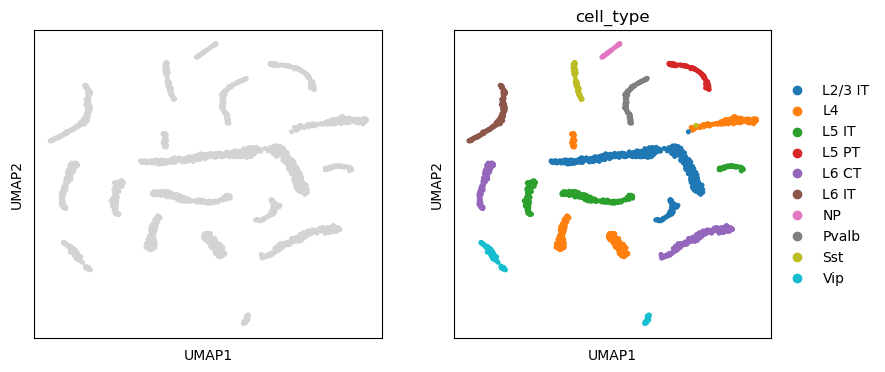

In [76]:
plt.rcParams["figure.figsize"]= (4, 4)
epi.pl.umap(adata_sim, color=[None, "cell_type"])